In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq, rfft, ifft
from IPython.display import Audio
import soundfile as sf
import tqdm
from copy import deepcopy
from operator import itemgetter
%matplotlib inline

In [ ]:
%env PERMALINK=https://raw.githubusercontent.com/andriipletinka/LA_Project/main
!wget -nc $PERMALINK/19-198-0034.wav

%env PERMALINK=https://raw.githubusercontent.com/andriipletinka/LA_Project/main
!wget -nc $PERMALINK/lincoln.wav

%env PERMALINK=https://raw.githubusercontent.com/andriipletinka/LA_Project/main
!wget -nc $PERMALINK/Mel_Scale.wav

%env PERMALINK=https://raw.githubusercontent.com/andriipletinka/LA_Project/main
!wget -nc $PERMALINK/Range_of_Human_Hearing.mp3


env: PERMALINK=https://raw.githubusercontent.com/andriipletinka/LA_Project/main
--2023-05-22 08:39:35--  https://raw.githubusercontent.com/andriipletinka/LA_Project/main/19-198-0034.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 532044 (520K) [audio/wav]
Saving to: ‘19-198-0034.wav’

19-198-0034.wav     100%[===================>] 519.57K  --.-KB/s    in 0.02s   

2023-05-22 08:39:36 (32.4 MB/s) - ‘19-198-0034.wav’ saved [532044/532044]

env: PERMALINK=https://raw.githubusercontent.com/andriipletinka/LA_Project/main
--2023-05-22 08:39:36--  https://raw.githubusercontent.com/andriipletinka/LA_Project/main/lincoln.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.

### Audiofile
We used the snippet of audiobook from LibriSpeech ASR corpus. Here's the link to the source: https://www.openslr.org/12.

In [ ]:
path = "lincoln.wav"
samples, sampling_rate = librosa.load(path)
Audio(samples, rate=sampling_rate)

### Time domain of the signal

Text(31.097222222222214, 0.5, 'Amplitude')

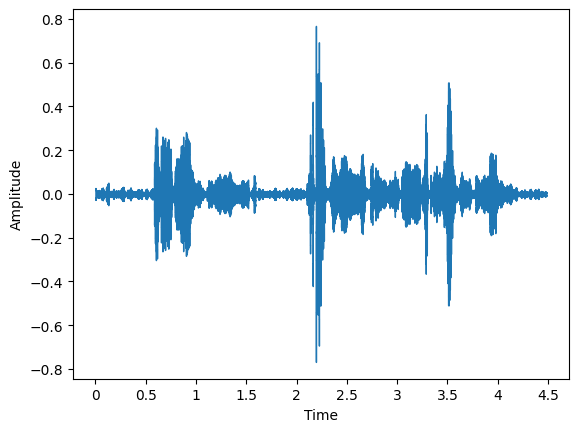

In [ ]:
librosa.display.waveshow(samples, sr=sampling_rate)
plt.ylabel("Amplitude")

### Spectrogram
The spectrogram represents the signal in the time-frequency domain. To get a spectrogram one should calculate FFT for small frames of input signal - Short-time Fourier Transform. More on STFT you can read in our report. After computing STFT, we get the intensity (the measure of presence) for different frequencies in different time periods. This gives us an opportunity to represent the audio in both time and frequency domains and present this representation as the spectrogram. The y-axis represents the frequencies and the x-axis represents the time. The lighter colors indicate more present frequencies while the darker colors indicates less intense presence of the frequency.

Text(0.5, 0, 'Time, s')

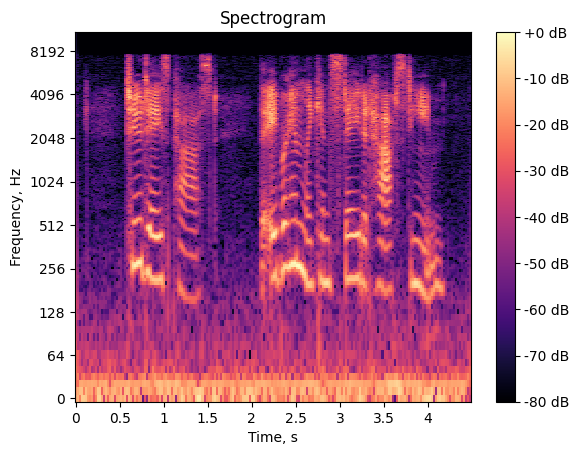

In [ ]:
spec = np.abs(librosa.stft(samples, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sampling_rate, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');
plt.ylabel("Frequency, Hz")
plt.xlabel("Time, s")

### Mel Spectrogram
The main difference between Mel and regular spectrogram is that it more 'human-oriented'. When we listen to sounds, we don't perceive all frequencies equally. We are more sensitive to lower frequency ranges than higher. The Mel scale reflects this by emphasizing lower frequencies and gradually spreading out the higher frequencies, as shown on this picture. You can also test this by listening to the audio in the chunk below, but be aware that this audio might be somewhat irritating. After listeting, one can observe that the difference in higher frequencies is less evident than in lower. Therefore, you can observe that the Mel spectrogram gives way less information about higher frequencies than the regular spectrogram.  


Mel-Hz_plot.svg

In [ ]:
Audio("Range_of_Human_Hearing.mp3")

Here the Mel-scaled audio of 200Hz to 1500Hz

In [ ]:
Audio("Mel_Scale.wav")

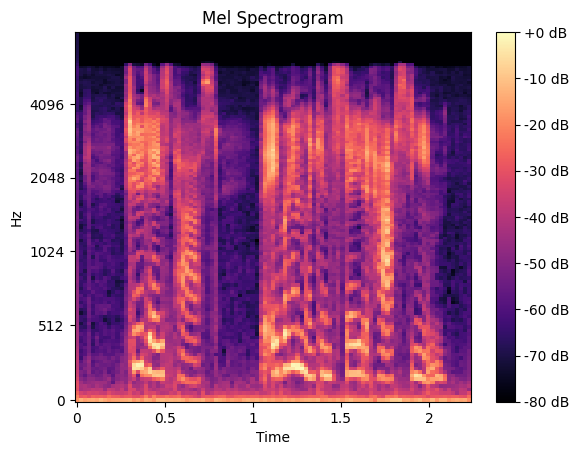

In [ ]:
mel_spect = librosa.feature.melspectrogram(y=samples, sr=sampling_rate, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

### Getting Noisy Audiofile

In [ ]:
def get_noise(data, noise_std = 0.1, mode='S', max_noise = 5e-1):
    noise = np.random.randn(*data.shape);
    if mode == 'B':
        n = noise.shape[0];
        noise_tensor_array = max_noise * np.random.random(n);
        for i in range(n):
            noise.data[i] = noise.data[i] * noise_tensor_array[i];
    else:
        noise = noise * noise_std;
    return noise

In [ ]:
audio, sr = librosa.load("lincoln.wav")
noise_sample = get_noise(audio)
noisy_audio = audio + 0.25*noise_sample

Here you can listen to audio file contaminated with noise.

In [ ]:
Audio(noisy_audio, rate=sr)

Text(31.097222222222214, 0.5, 'Amplitude')

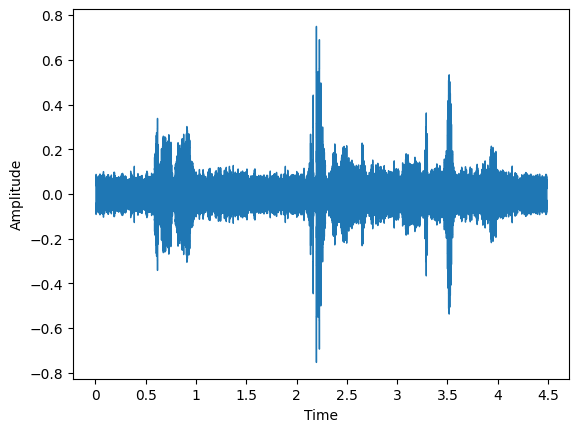

In [ ]:
librosa.display.waveshow(noisy_audio, sr=sr)
plt.ylabel("Amplitude")

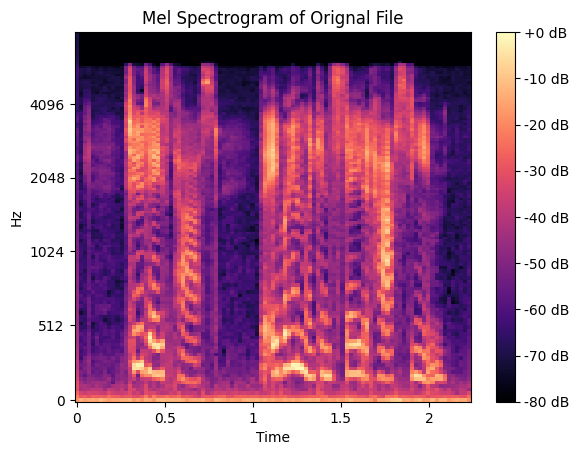

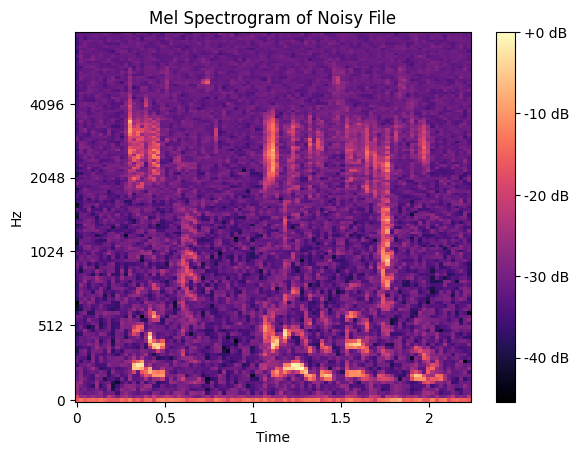

In [ ]:
mel_spect = librosa.feature.melspectrogram(y=audio, sr=sampling_rate, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram of Orignal File')
plt.colorbar(format='%+2.0f dB')
plt.show()

mel_spect = librosa.feature.melspectrogram(y=noisy_audio, sr=sampling_rate, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram of Noisy File')
plt.colorbar(format='%+2.0f dB')
plt.show()

These two Mel spectrogtams can be used to compare original and corrupted files. You can notice that the dB scales changed for corrupted file, scince there is way less variation in intensity for different frequencies. Thus, our dB scale should be more informative to correctly represent the difference for different frequencies.

In [ ]:
frame_length = 0.05
samples = audio[:sampling_rate*4]
number_of_frames = int(4 * 1/frame_length)
samples_per_frame = int(frame_length * sampling_rate)
xf = fftfreq(samples_per_frame, 1/sampling_rate)
max_notes = []
max_amp = 0

for i in range(number_of_frames):
  frame_sample = samples[i*samples_per_frame: i*samples_per_frame + samples_per_frame]
  frame_fft = fft(frame_sample)
  frame_fft = np.abs(frame_fft).real
  max_amp = max(np.max(frame_fft), max_amp)

for i in tqdm.tqdm(range(number_of_frames)):
  frame_sample = samples[i*samples_per_frame: i*samples_per_frame + samples_per_frame]
  frame_fft = rfft(frame_sample)
  frame_fft = np.abs(frame_fft) / max_amp
  plt.plot(xf[:samples_per_frame//2], frame_fft[:samples_per_frame//2])
  plt.xlim(0, 4500)
  plt.ylim(0, 1)
  plt.xlabel("Frequency(Hz)")
  plt.ylabel("Magnitude")
  plt.savefig(f"/content/original{i}.png")
  plt.clf()

100%|██████████| 80/80 [00:11<00:00,  6.78it/s]


<Figure size 640x480 with 0 Axes>

In [ ]:
sf.write("original.wav", audio[:sr*4], sr)

In [ ]:
frame_length = 0.05
samples = noisy_audio[:sampling_rate*4]
number_of_frames = int(4 * 1/frame_length)
samples_per_frame = int(frame_length * sampling_rate)
xf = fftfreq(samples_per_frame, 1/sampling_rate)
max_notes = []
max_amp = 0

for i in range(number_of_frames):
  frame_sample = samples[i*samples_per_frame: i*samples_per_frame + samples_per_frame]
  frame_fft = fft(frame_sample)
  frame_fft = np.abs(frame_fft).real
  max_amp = max(np.max(frame_fft), max_amp)

for i in tqdm.tqdm(range(number_of_frames)):
  frame_sample = samples[i*samples_per_frame: i*samples_per_frame + samples_per_frame]
  frame_fft = rfft(frame_sample)
  frame_fft = np.abs(frame_fft) / max_amp
  plt.plot(xf[:samples_per_frame//2], frame_fft[:samples_per_frame//2])
  plt.xlim(0, 4500)
  plt.ylim(0, 1)
  plt.xlabel("Frequency(Hz)")
  plt.ylabel("Magnitude")
  plt.savefig(f"/content/noisy{i}.png")
  plt.clf()

100%|██████████| 80/80 [00:11<00:00,  6.74it/s]


<Figure size 640x480 with 0 Axes>

In [ ]:
sf.write("noisy.wav", noisy_audio[:sr*4], sr)

In [ ]:
!ffmpeg -y -r {20} -f image2 -s 1920x1080 -i original%d.png -i {"original.wav"} -c:v libx264 -pix_fmt yuv420p original.mp4

In [ ]:
!ffmpeg -y -r {20} -f image2 -s 1920x1080 -i noisy%d.png -i {"noisy.wav"} -c:v libx264 -pix_fmt yuv420p noisy.mp4

In [ ]:
from IPython.display import HTML
from base64 import b64encode
video_file = open("/content/original.mp4", "r+b").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={600} controls><source src="{video_url}""></video>""")

In [ ]:
video_file = open("/content/noisy.mp4", "r+b").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={600} controls><source src="{video_url}""></video>""")

The above two videos can also be used two compare two audio files. You can observe small peaks along the whole x-axis in the video for the noisy audio. These peaks correspond to added noise.

### Performing Trivial Denoising
In this section we perform a trivial denoising technique. The main idea is to compute STFT and for each frame of STFT we determine the mean and standart deviation. Then for every coeficient in this frame we apply hard treshholding:
$$\begin{equation}
  f_k(x)=\begin{cases}
    x, & \text{if $x> \mu_k + 2.5*\sigma_k$}.\\
    0, & \text{otherwise}.
  \end{cases}
\end{equation}$$
Where $k$ is the number of the frame and $\mu_k + 2.5*\sigma_k$ is a treshold which is usually denoted $λ$. Please note that we chose this treshold just for example. <br>
After setting coefficients of unwanted frequencies to zero, we perform Inverse STFT to retrieve the samples and then audio.



In [ ]:
stf_transform = signal.stft(noisy_audio, sr)
denoised_trivial_stft = stf_transform[2]
stft_abs = np.abs(stf_transform[2])

In [ ]:
for i in range(len(denoised_trivial_stft)):
  mean = np.mean(stft_abs[i])
  std = np.std(stft_abs[i])
  mask = stft_abs[i] > mean + 2.5*std
  denoised_trivial_stft[i] = denoised_trivial_stft[i] * mask
reduced_noise_trivial = signal.istft(denoised_trivial_stft, sampling_rate)

In [ ]:
sf.write("reduced_noise_trivial.wav", reduced_noise_trivial[1], sr)

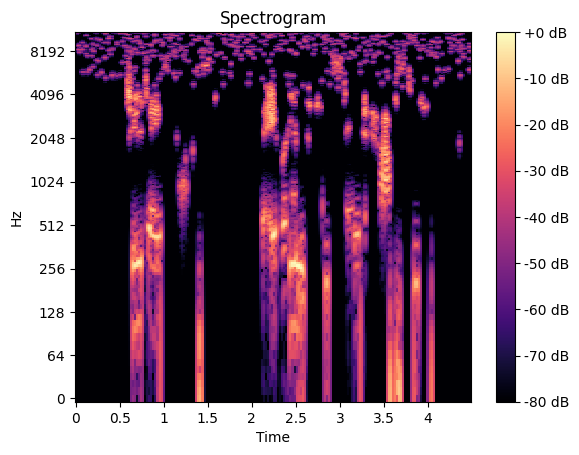

In [ ]:
spec = np.abs(librosa.stft(reduced_noise_trivial[1], hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sampling_rate, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');
Audio(reduced_noise_trivial[1], rate=sr)

After listening to the audio, we hear a strange sounds. This is called a 'musical' noise. It is not the most prominent example of musical noise, but still it is easy to distinguish. This sort of noise occurs when the distinct sinusoid are being present in the audio. Since, it is really hard to hear the pure sinusoids in nature, it is rather not pleasant to hear. So, the trivial denoising technique is proved to deliver bad results.

## Block Threshholding

For the block tresholding technique we also apply the hard tresholding. The main difference is that now we do it on the blocks, not frames as in previous method. For easier understanding the block can be interpreted as a $n \times m$ part of the spectrogram. For each of these blocks we calculate the norm (putting all STFT coefficients that belong to the block to the power of 2 and sum them up). Then we compare the norms with some treshold and if the norm of the block is lower than the treshold we delete the whole block out of spectrogram (set STFT coefficients to zero). Then we do the same procedure as in trivial method, by computing ISTFT and obtaining audio.

In [ ]:
def get_block_L2_norm(mat, window_size):

    kernel = np.ones([window_size, window_size]);

    out = signal.convolve2d(mat**2, kernel, boundary='fill', mode='same')

    return out

In [ ]:
def stft_block_denoising(source, noise_std, fs, nperseg, block_thresh, window_size, noise_sample = None, ind=0):

    if noise_sample is None:
        noisy = source + 0.25*get_noise(source, noise_std);
    else:
        noisy = source + 0.25*noise_sample

    source_stft = signal.stft(source, fs = fs, nperseg=nperseg);
    noisy_stft = signal.stft(noisy, fs = fs, nperseg=nperseg);

    block_denoised_stft = deepcopy(noisy_stft);

    Zxx = noisy_stft[2];
    abs_Zxx_block_L2_norm = get_block_L2_norm(np.abs(Zxx), window_size);

    block_denoised_stft = list(block_denoised_stft)
    block_denoised_stft[2] = np.where(abs_Zxx_block_L2_norm >= block_thresh, Zxx, 0);

    _, source_istft =  signal.istft(source_stft[2], fs=fs, nperseg=nperseg);
    _, block_denoised_istft =   signal.istft(block_denoised_stft[2], fs=fs, nperseg=nperseg);


    return np.real(source_istft), np.real(block_denoised_istft)

In [ ]:
nperseg = 512
window_size = 5

source, block_denoised = stft_block_denoising(audio, 0.1, sr, nperseg, 0.00025, window_size, noise_sample)

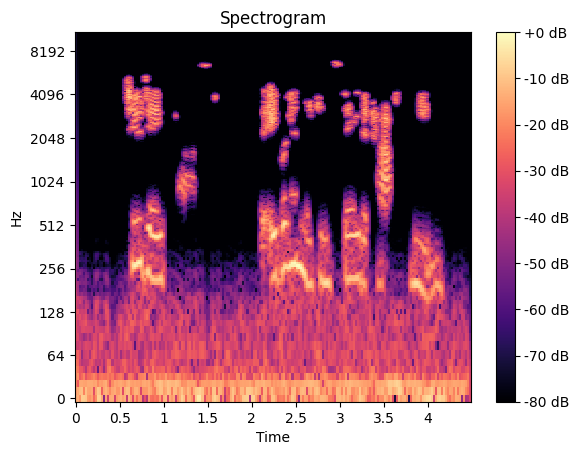

In [ ]:
spec = np.abs(librosa.stft(block_denoised, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');
Audio(noisy_audio, rate=sr)
Audio(block_denoised, rate=sr)

We can observe that block tresholding does not leave pure sinusoids and therefore does not produce musical noise.

### Tuning 'Hyperparameters'
In this section we want to find the best value for the threshold. We do it by calculating the MSE between samples of orignal and denoised audios.  

In [ ]:
tresholds = np.linspace(0, 0.001, 150)
results = []

for i in tqdm.tqdm(range(tresholds.size)):
  source, block_denoised_test = stft_block_denoising(audio, 0.1, sr, nperseg, tresholds[i], window_size, noise_sample)
  mse = np.linalg.norm(block_denoised_test - source)**2
  results.append([i, mse])

results = sorted(results, key=itemgetter(1))
print(f"\nThe best MSE score is for {tresholds[results[0][0]]} threshold.")
print(results)

100%|██████████| 150/150 [00:08<00:00, 18.66it/s]


The best MSE score is for 0.00011409395973154363 threshold.
[[17, 11.078234118577678], [16, 11.11716245547375], [18, 11.128047544745627], [15, 11.165109379324251], [19, 11.222554571552353], [14, 11.29306488664857], [20, 11.324905624534885], [21, 11.483848226024383], [22, 11.605516349316567], [13, 11.615973579467328], [23, 11.726373484468851], [24, 11.90416260484473], [25, 12.06053611809987], [26, 12.216678987868455], [27, 12.357277748233747], [12, 12.38790366529035], [28, 12.527099777172957], [29, 12.761494445270154], [30, 12.926817652678636], [31, 13.172109050770946], [32, 13.359989674999927], [33, 13.508510841854333], [34, 13.727408592299929], [11, 13.807279649132605], [35, 13.917494639897255], [36, 14.173263085722603], [37, 14.281616922429704], [38, 14.487380144208956], [39, 14.694693275970263], [40, 14.917676293475058], [41, 15.090974303171585], [42, 15.333816642208287], [43, 15.447741900823463], [44, 15.588883098828246], [45, 15.778873961004468], [46, 15.968981223045372], [47, 16

In [ ]:
source, block_denoised_tresh_best = stft_block_denoising(audio, 0.1, sr, nperseg, tresholds[results[0][0]], window_size, noise_sample)

In [ ]:
sf.write("block_denoised_tresh_best.wav", block_denoised_tresh_best, sr)

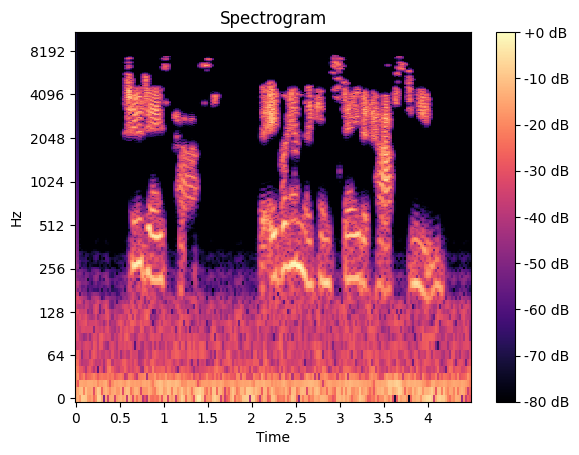

In [ ]:
spec = np.abs(librosa.stft(block_denoised_tresh_best, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');
Audio(noisy_audio, rate=sr)
Audio(block_denoised_tresh_best, rate=sr)

The result is better than the one in the previous section. We stated in our report that this technique does not always produce good results, but for our example it did pretty good.